In [1]:
import numpy as np
import pandas as pd

from lingam.utils import make_dot
from IPython.display import display, Markdown
import matplotlib.pyplot as plt

from sklearn.dummy import DummyRegressor

from lingam.utils import make_dot
from lingam import CausalBasedSimulator, CBSILiNGAM, CBSITimeSeriesLiNGAM

In [2]:
size = 1000

# k=2
B = np.array([
[
    [0,-0.12,0,0,0],
    [0,0,0,0,0],
    [-0.41,0.01,0,-0.02,0],
    [0.04,-0.22,0,0,0],
    [0.15,0,-0.03,0,0],
],
[
    [-0.32,0,0.12,0.32,0],
    [0,-0.35,-0.1,-0.46,0.4],
    [0,0,0.37,0,0.46],
    [-0.38,-0.1,-0.24,0,-0.13],
    [0,0,0,0,0],
]
])

e = lambda: np.random.uniform(-np.sqrt(3), np.sqrt(3), size=(n_features, 1))

# Xは上ほど古く、下ほど若い
# 初期値：1時点前のデータが必要になるので入れておく。
n_features = B.shape[1]
X = e()

# ひとつ前の時刻までのデータを与えると、現在時刻のデータを返す。
def x_t(X):
    # (I - B_0)^-1
    term = np.linalg.pinv(np.eye(n_features) - B[0])
    
    # Sigma[B_tau @ x(t-tau)] + e(t)
    # Bは横につなげて、Xは縦につなげる
    # Bの2番目以降を横に連結、Xの最新からBの2番目以降との積をとる部分を縦に連結して、行列の積
    term2 = np.hstack(B[1:]) @ np.hstack(X[:, ::-1][:, :len(B) - 1]).reshape(5, 1) + e()

    return term @ term2

# 各時刻ごとにデータを生成していく
for t in range(len(B) - 1, size):
    X = np.append(X, x_t(X[:, :t]), axis=1)
X = X.T

In [3]:
X

array([[ 1.35406632, -1.66798472,  0.25147674, -1.19754301, -0.95824157],
       [ 0.66838972, -0.84621439, -1.60313935,  1.14205755,  0.18015703],
       [-0.09800562, -1.39713504, -1.59181491, -0.92815775, -1.3874746 ],
       ...,
       [ 0.90789897, -1.57314124, -1.14411599, -1.58926636,  1.79289129],
       [-0.0117506 ,  3.5016838 ,  1.50335034, -2.0677912 ,  0.04757836],
       [-1.01115074, -1.74955198,  1.19971802, -1.31002034,  0.07985271]])

In [4]:
from sklearn.utils import check_array 
check_array(B, allow_nd=True)

array([[[ 0.  , -0.12,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [-0.41,  0.01,  0.  , -0.02,  0.  ],
        [ 0.04, -0.22,  0.  ,  0.  ,  0.  ],
        [ 0.15,  0.  , -0.03,  0.  ,  0.  ]],

       [[-0.32,  0.  ,  0.12,  0.32,  0.  ],
        [ 0.  , -0.35, -0.1 , -0.46,  0.4 ],
        [ 0.  ,  0.  ,  0.37,  0.  ,  0.46],
        [-0.38, -0.1 , -0.24,  0.  , -0.13],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ]]])

## CBSITimeSeriesLiNGAMの確認

In [5]:
impl = CBSITimeSeriesLiNGAM(X, B)

In [6]:
impl._n_lags

1

In [7]:
# ラグ側へのエッジやラグ内でのエッジは作らない形でひとつの隣接行列化している。
pd.DataFrame(
    impl._causal_graph,
    columns=impl._endog_names,
    index=impl._endog_names
)

,0[0],1[0],2[0],3[0],4[0],0[1],1[1],2[1],3[1],4[1]
0[0],0.00,-0.12,0.00,0.00,0.0,-0.32,0.00,0.12,0.32,0.00
1[0],0.00,0.00,0.00,0.00,0.0,0.00,-0.35,-0.10,-0.46,0.40
2[0],-0.41,0.01,0.00,-0.02,0.0,0.00,0.00,0.37,0.00,0.46
3[0],0.04,-0.22,0.00,0.00,0.0,-0.38,-0.10,-0.24,0.00,-0.13
4[0],0.15,0.00,-0.03,0.00,0.0,0.00,0.00,0.00,0.00,0.00
0[1],0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00
1[1],0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00
2[1],0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00
3[1],0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00
4[1],0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00


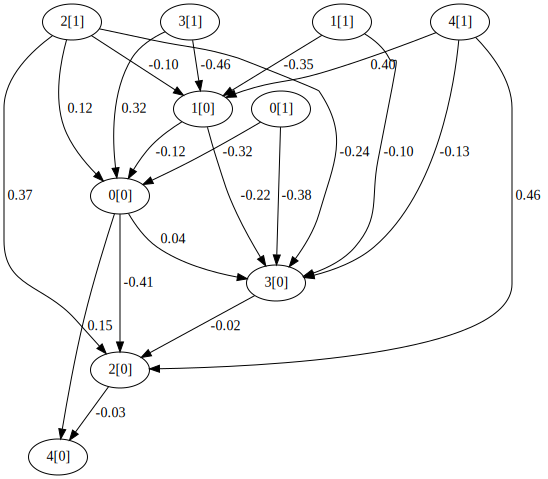

In [8]:
make_dot(impl._causal_graph, labels=impl._endog_names)

In [9]:
d = impl.get_data(impl._endog_names)

# ラグ分だけサンプルが減る
print(d.shape)

# 先頭3行
pd.DataFrame(d[:3], columns=impl._endog_names)

(999, 10)


,0[0],1[0],2[0],3[0],4[0],0[1],1[1],2[1],3[1],4[1]
0,0.668390,-0.846214,-1.603139,1.142058,0.180157,1.354066,-1.667985,0.251477,-1.197543,-0.958242
1,-0.098006,-1.397135,-1.591815,-0.928158,-1.387475,0.668390,-0.846214,-1.603139,1.142058,0.180157
2,0.504992,0.200019,-2.681989,0.564045,0.870505,-0.098006,-1.397135,-1.591815,-0.928158,-1.387475


In [10]:
# 参考：元データ。先頭は過去データが無いうちは削除されている。
pd.DataFrame(X[:5])

,0,1,2,3,4
0,1.354066,-1.667985,0.251477,-1.197543,-0.958242
1,0.668390,-0.846214,-1.603139,1.142058,0.180157
2,-0.098006,-1.397135,-1.591815,-0.928158,-1.387475
3,0.504992,0.200019,-2.681989,0.564045,0.870505
4,0.526685,1.858130,-0.468167,0.446844,1.256343


## CausalBasedSimulator

### train()とその結果

In [11]:
sim = CausalBasedSimulator()
sim.train(X, B, cd_algo_name="VARLiNGAM")

In [12]:
df = []
for k, v in sim.train_result_.items():
    df.append({"キー":k, "モデル":v["model"], "親変数":v["parent_names"], "誤差項の長さ":v["residual"].shape})
pd.DataFrame(df)

,キー,モデル,親変数,誤差項の長さ
0,0[0],LinearRegression(),"[1[0], 0[1], 2[1], 3[1]]","(999,)"
1,1[0],LinearRegression(),"[1[1], 2[1], 3[1], 4[1]]","(999,)"
2,2[0],LinearRegression(),"[0[0], 1[0], 3[0], 2[1], 4[1]]","(999,)"
3,3[0],LinearRegression(),"[0[0], 1[0], 0[1], 1[1], 2[1], 4[1]]","(999,)"
4,4[0],LinearRegression(),"[0[0], 2[0]]","(999,)"
5,0[1],None,[],"(999,)"
6,1[1],None,[],"(999,)"
7,2[1],None,[],"(999,)"
8,3[1],None,[],"(999,)"
9,4[1],None,[],"(999,)"


### run()

In [13]:
# 結果可視化用
def vis(simulated, data):
    n_features = B.shape[1]
    
    fig, axes = plt.subplots(1, n_features, figsize=(n_features*3, 3))
    for i in range(n_features):
        axes[i].scatter(simulated.iloc[:, i], data.iloc[:, i])
        axes[i].set_aspect("equal", "box")
        axes[i].axline((0, 0), (1, 1), color="black", lw=1)
        axes[i].set_xlabel("simulated")
        axes[i].set_ylabel("true")
        axes[i].set_title(f"name={simulated.columns[i]}")
    plt.tight_layout()
    plt.show()
    
    fig, axes = plt.subplots(1, n_features, figsize=(n_features*3, 3))
    for i in range(n_features):
        range_ = [*data.iloc[:, i], *simulated.iloc[:, i]]
        range_ = min(range_), max(range_)
        
        axes[i].hist(data.iloc[:, i], label="true", range=range_, alpha=0.5)
        axes[i].hist(simulated.iloc[:, i], label="sim", range=range_, alpha=0.5)
        axes[i].legend()
    plt.tight_layout()
    plt.show()

#### 引数無し

(999, 10)


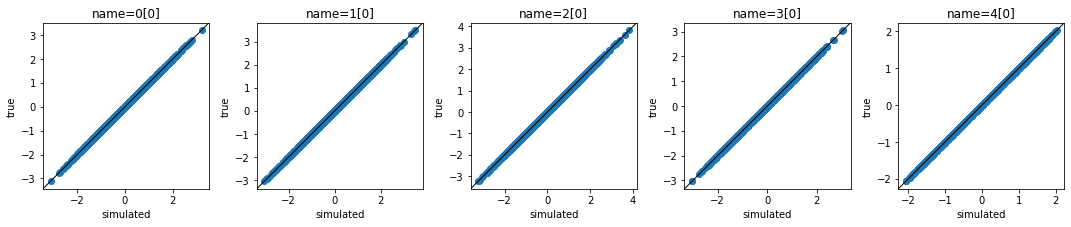

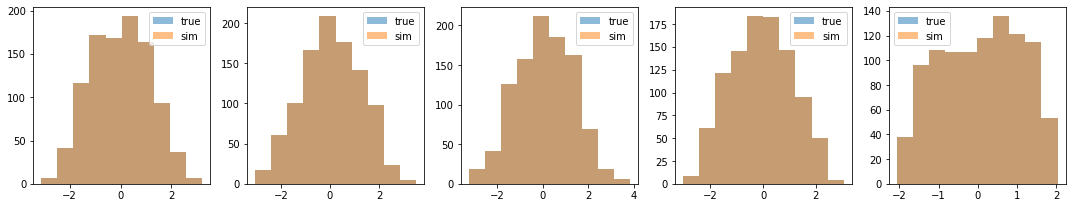

In [14]:
simulated = sim.run()

# ラグ分(B.shape[0] - 1)だけサンプルが先頭側(ふるい側)から減る。
print(simulated.shape)

vis(simulated.iloc[:, :X.shape[1]], pd.DataFrame(X[1:]))

#### 誤差項シャッフル

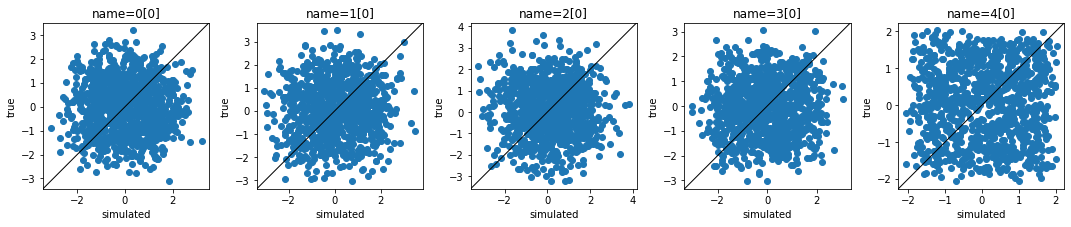

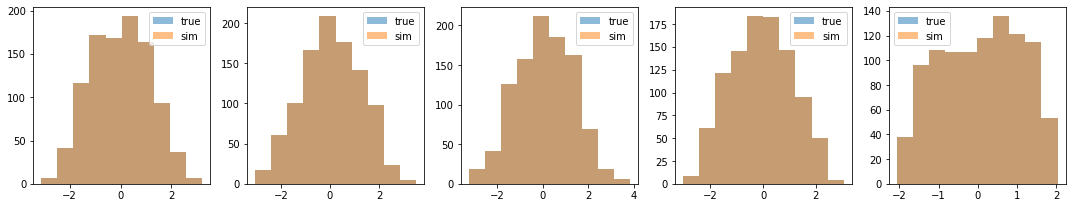

In [15]:
simulated = sim.run(shuffle_residual=True)
vis(simulated.iloc[:, :X.shape[1]], pd.DataFrame(X[1:]))

#### エッジ変更
0[0]を外生化。子である2[0]、3[0]、4[0]が影響を受ける。

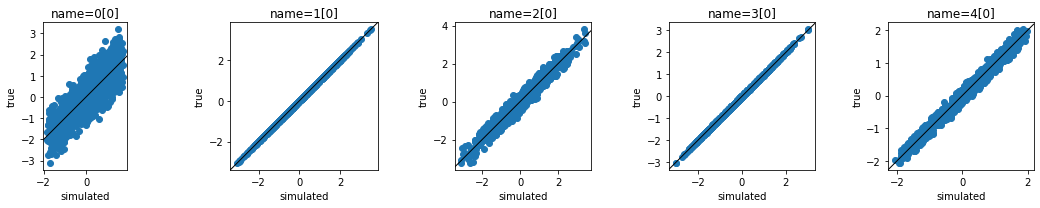

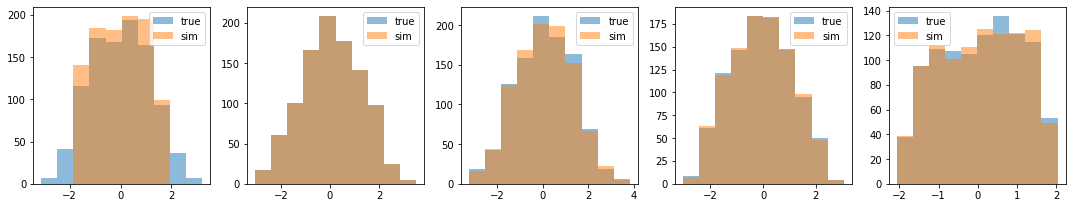

In [16]:
changing_models = {
    "0[0]": {"parent_names": None, "model": None, "coefs": None}
}
simulated = sim.run(changing_models=changing_models)
vis(simulated.iloc[:, :X.shape[1]], pd.DataFrame(X[1:]))